In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/backend')
!pwd

/content/drive/MyDrive/Colab Notebooks/backend


In [ ]:
!python Notebooks/utils.py

2025-12-07 20:23:36.806448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765139016.875718    2455 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765139016.901358    2455 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765139016.964501    2455 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765139016.964557    2455 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765139016.964569    2455 computation_placer.cc:177] computation placer alr

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/backend/Notebooks')

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import utils
from importlib import reload
reload(utils)

<module 'utils' from 'f:\\Twitter-Sentiment\\backend\\Notebooks\\utils.py'>

In [ ]:
Chunk_index=1
batch_size=32
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1000
NUM_LABELS=1
train_ratio=0.70
val_ratio=0.15
test_ratio=0.15

In [ ]:
#Loading the Chunked Data
texts, targets = utils.load_dataframe(Chunk_index)
print(texts[:5])
print(targets[:5])

['@user thanks 4 including me in your shoutout', "No santigold for me tonight. work til 10 and I'm off tomorrow", '@user for realz! Safe travels- hope things go much more smoothly this time around. &amp; that you are having a great day so far!', '@user you asked about my SF schedule, dahling...maybe next time', 'My throat kinda hurts']
[1, 1, 1, 1, 0]


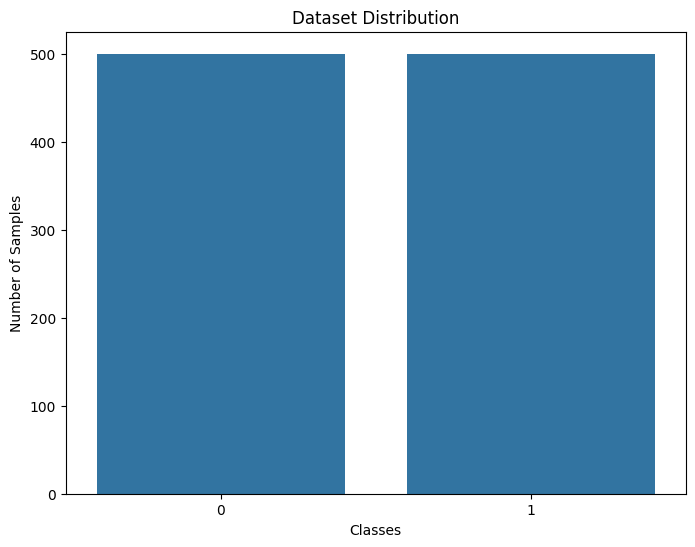

In [ ]:
#Visualizing the Entire Chunk
utils.plot_dataset_distribution(texts, targets)

In [ ]:
#Loading the Tokenizer
Distill_Tokenizer = utils.load_tokenizer('distilbert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#Function to Tokenize the Data
def tokenize_data(text_list, label_list):
  encodings = Distill_Tokenizer(
      text_list,
      truncation=True,
      padding='max_length',
      max_length=128
  )
  inputs = {k: tf.constant(v) for k, v in encodings.items()}
  labels = tf.constant(label_list)
  return inputs, labels

In [ ]:
#Loading the Distill Bert Model from the Utils
DistillBert_model=utils.load_distilbert_checkpoint('/content/drive/MyDrive/Colab Notebooks/backend/chunk_model1.h5',NUM_LABELS)

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

In [ ]:
DistillBert_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5,weight_decay=0.01,beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
DistillBert_model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66954241 (255.41 MB)
Trainable params: 66954241 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def split_dataset(texts, targets):
    train_texts, temp_texts, train_targets, temp_targets = train_test_split(
        texts, targets, test_size=(val_ratio + test_ratio), stratify=targets, random_state=42
    )

    val_texts, test_texts, val_targets, test_targets = train_test_split(
        temp_texts, temp_targets,
        test_size=test_ratio/(val_ratio + test_ratio),
        stratify=temp_targets, random_state=42
    )

    train_inputs, train_labels = tokenize_data(train_texts, train_targets)
    val_inputs, val_labels = tokenize_data(val_texts, val_targets)
    test_inputs, test_labels = tokenize_data(test_texts, test_targets)

    train_ds = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)) \
                            .shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)) \
                          .batch(SHUFFLE_BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)) \
                           .batch(SHUFFLE_BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds,val_ds,test_ds=split_dataset(texts,targets)

In [ ]:
epochs=5

es=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    verbose=1,
    restore_best_weights=True
)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('chunk_model1.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [ ]:
# Training Loop for Chunks

start = 42
end = 101

all_test =[]
all_history=[]
for i in range(start, end):

    print(f"\n🔹 Training for Chunk {i}")

    # Load the dataframe for chunk i
    text, target = utils.load_dataframe(i)

    # Split
    train_ds, val_ds, test_ds = split_dataset(text, target)

    all_test.append(test_ds)

    # Train for this chunk
    history=DistillBert_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[es, rlr, mc]
    )

    all_history.append(history)


🔹 Training for Chunk 42
Epoch 1/5
 1/22 [>.............................] - ETA: 48:37 - loss: 0.4831 - accuracy: 0.7500

KeyboardInterrupt: 

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for h in all_histories:
    train_acc.extend(h["accuracy"])
    val_acc.extend(h["val_accuracy"])
    train_loss.extend(h["loss"])
    val_loss.extend(h["val_loss"])

utils.plot_accuracy(train_acc, val_acc)
utils.plot_loss(train_loss, val_loss)

In [ ]:
final_test_ds = all_test[0]
for ds in all_test[1:]:
    final_test_ds = final_test_ds.concatenate(ds)
results=DistillBert_model.evaluate(final_test_ds)


In [ ]:
y_true = []
y_pred = []
y_scores = []

for batch in final_test_ds:
    inputs, labels = batch
    predictions = DistillBert_model.predict(inputs)

    # Convert logits to probabilities
    logits = predictions.logits
    prob = tf.nn.sigmoid(logits)[0][0].numpy()

    # Binary labels
    predicted_labels = (prob > 0.5).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)
    y_scores.extend(prob)
# Confusion matrix
utils.plot_confusion_matrix(y_true, y_pred)

# Precision-Recall curve
utils.plot_precision_recall(y_true, y_scores)

# ROC curve
utils.plot_roc_curve(y_true, y_scores)
